In [103]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Data set: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [104]:
# Load the dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
data_raw <- read_csv(url, col_names = names)
data_raw

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [105]:
# DESCRIPTION OF VARIABLES
# age, in years
# sex (1 = male; 0 = female)
# cp: chest pain type
#     -- Value 1: typical angina
#     -- Value 2: atypical angina
#     -- Value 3: non-anginal pain
#     -- Value 4: asymptomatic
# trestbps: resting blood pressure (in mm Hg on admission to the hospital)
# chol: serum cholestoral in mg/dl
# fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
# restecg: resting electrocardiographic results
#     -- Value 0: normal
#     -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST 
#                 elevation or depression of > 0.05 mV)
#     -- Value 2: showing probable or definite left ventricular hypertrophy
#                 by Estes' criteria
# thalach: maximum heart rate achieved
# exang: exercise induced angina (1 = yes; 0 = no)
# oldpeak = ST depression induced by exercise relative to rest
# slope: the slope of the peak exercise ST segment
#     -- Value 1: upsloping
#     -- Value 2: flat
#     -- Value 3: downsloping
# ca: number of major vessels (0-3) colored by flourosopy
# thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
# num: diagnosis of heart disease (angiographic disease status)
#     -- Value 0: < 50% diameter narrowing
#     -- Value 1: > 50% diameter narrowing

In [106]:
# Possible predictors:
#  - chol (serum cholesterol)
#  - trestbps (resting blood pressure)
#  - age
#  - thalach (maximum heart rate)
# Possible target variable:
#  - cp (chest pain type)
#  - num (diagnosis of heart disease)
# angina is chest pain or discomfort caused by a lack of oxygen rich blood

In [107]:
# Wrangle data
data <- data_raw %>%
    select(c("age", "cp", "trestbps", "thalach", "chol", "num")) %>% # select only columns that are used
    mutate(cp = as_factor(cp), # update target variables to factor
          num = as_factor(num)) 
data

age,cp,trestbps,thalach,chol,num
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
63,1,145,150,233,0
67,4,160,108,286,2
67,4,120,129,229,1
⋮,⋮,⋮,⋮,⋮,⋮
57,4,130,115,131,3
57,2,130,174,236,1
38,3,138,173,175,0


In [108]:
# Experiment: use only two target variable classes
# classify num to either 0 (no visible heart disease) or 1-4 (mild heart disease to very severe)
data_exp <- data %>%
    mutate(num = as_factor(ifelse(num == 0, 0, 1)))
data_exp
data <- data_exp
# for cp, can classify as either 0-1 (no angina) or 2-3 (angina)

age,cp,trestbps,thalach,chol,num
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
63,1,145,150,233,0
67,4,160,108,286,1
67,4,120,129,229,1
⋮,⋮,⋮,⋮,⋮,⋮
57,4,130,115,131,1
57,2,130,174,236,1
38,3,138,173,175,0


In [109]:
# Split into training data and testing data
set.seed(1) # set the seed

heart_split = initial_split(data, prop = 0.75, strata = num)
heart_training = training(data_split)
heart_testing = testing(data_split)

## Preliminary Exploratory Data Analysis

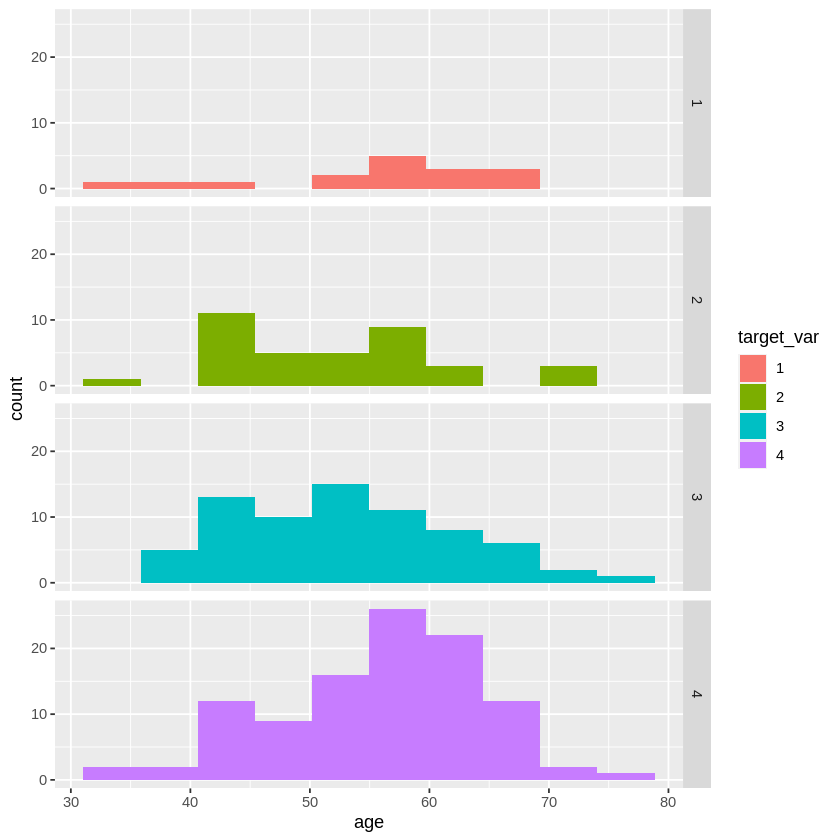

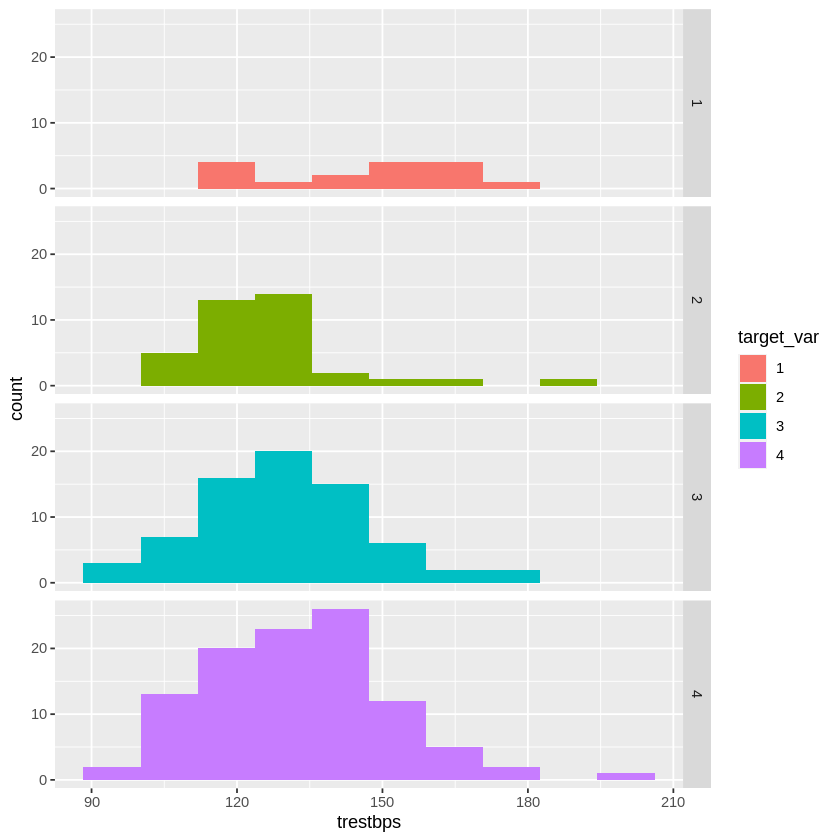

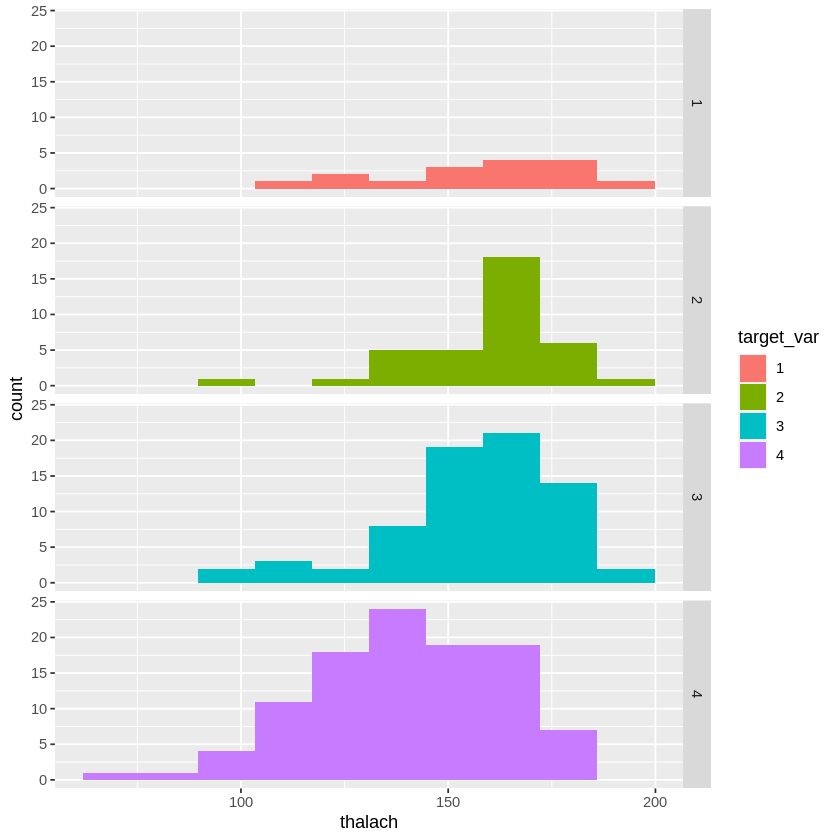

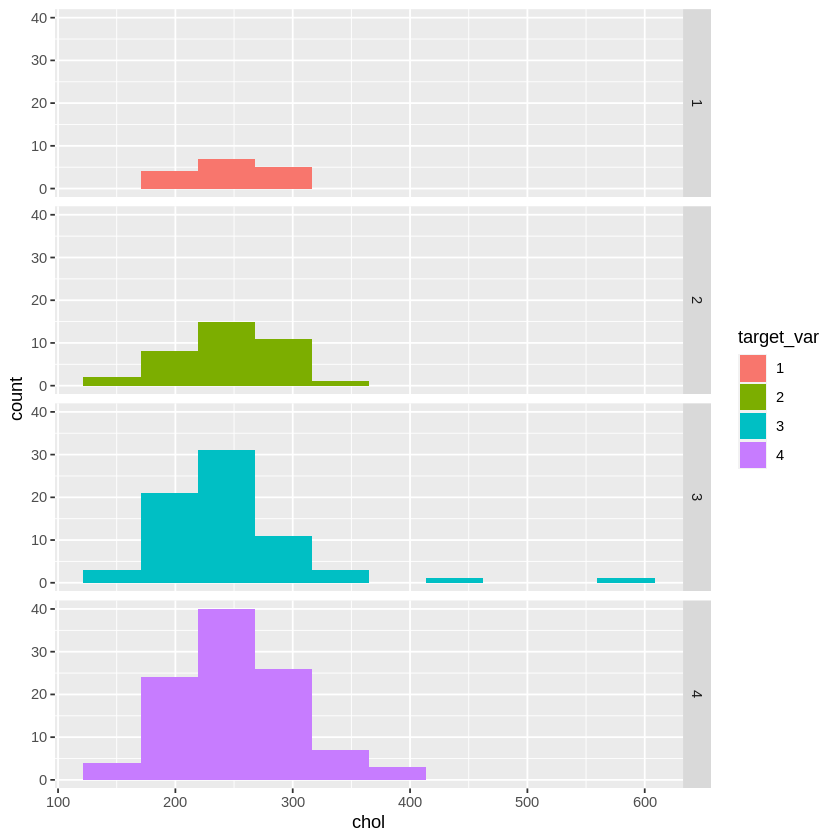

In [242]:
# Histograms for numerical predictor variables
bins_num = ceiling(log(nrow(data),2))+1 # number of bins, by Sturges' formula
theme_set(theme_grey())
target_var = data_training$num # target variable, to split up histograms by (data$num or data$cp)

ggplot(heart_training, aes(x = age, fill = target_var)) +
    geom_histogram(bins = bins_num) +
    facet_grid(rows = target_var)
ggplot(heart_training, aes(x = trestbps, fill = target_var)) +
    geom_histogram(bins = bins_num) +
    facet_grid(rows = target_var)
ggplot(heart_training, aes(x = thalach, fill = target_var)) +
    geom_histogram(bins = bins_num) +
    facet_grid(rows = target_var)
ggplot(heart_training, aes(x = chol, fill = target_var)) +
    geom_histogram(bins = bins_num) +
    facet_grid(rows = target_var)

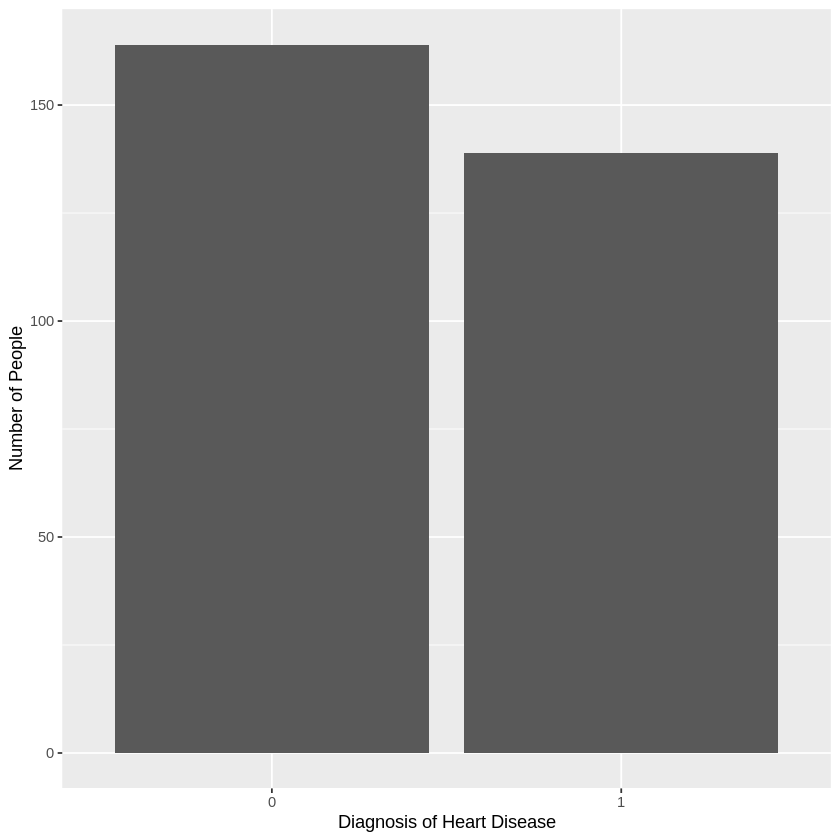

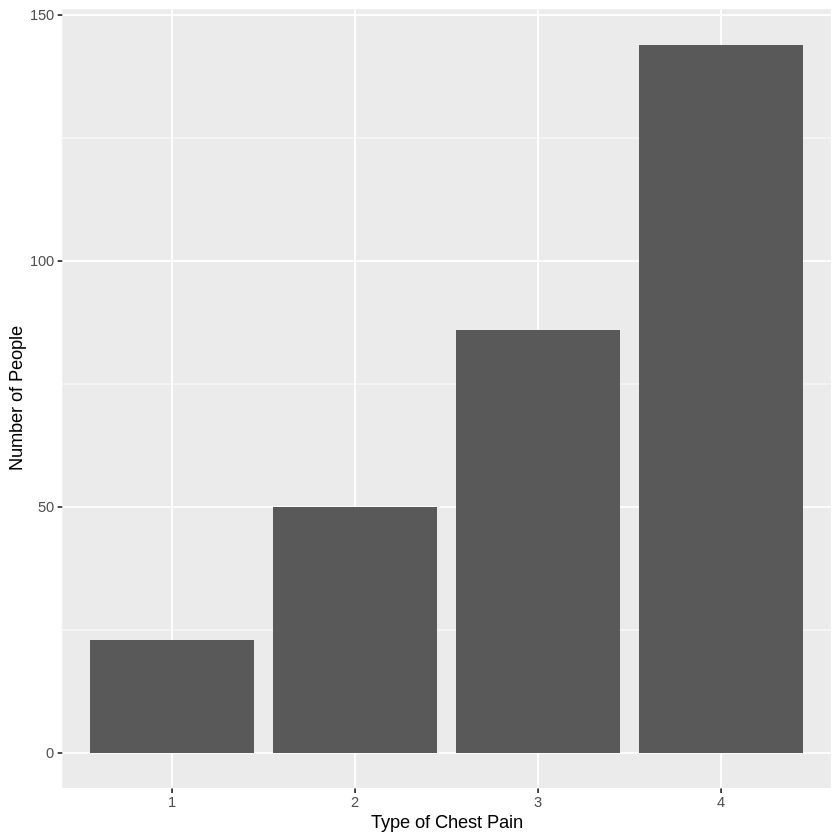

In [111]:
# Bar plots for (potential) target variables
ggplot(data, aes(x = num)) +
    geom_bar() +
    xlab("Diagnosis of Heart Disease") +
    ylab("Number of People")
ggplot(data, aes(x = cp)) +
    geom_bar() +
    xlab("Type of Chest Pain") +
    ylab("Number of People")

In [112]:
# plot <- ggplot(data, aes(x = chol, y = trestbps, color = cp)) + 
#     geom_point()
# plot

## Methods

In [113]:
# finalize methods

## Expected Outcomes

In [234]:
# Create recipe, choose target and predictor variables
# age + trestbps + thalach + chol
heart_recipe <- recipe(cp ~ age + trestbps + thalach + chol, data = heart_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

In [235]:
# # Create model with specific value of k (no cross-validation)
# knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) %>%
#     set_engine("kknn") %>%
#     set_mode("classification")

# # Fit model
# heart_fit <- workflow() %>%
#     add_recipe(heart_recipe) %>%
#     add_model(knn_spec) %>%
#     fit(data = heart_training)

In [236]:
heart_test_predictions <- predict(heart_fit, heart_testing) %>%
    bind_cols(heart_testing)
heart_test_predictions

.pred_class,age,cp,trestbps,thalach,chol,num
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
1,57,4,140,148,192,0
0,56,2,140,153,294,0
1,64,1,110,144,211,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,45,1,110,132,264,1
1,68,4,144,141,193,1
1,57,4,130,115,131,1


In [237]:
heart_prediction_accuracy <- heart_test_predictions %>%
        metrics(truth = num, estimate = .pred_class)  
heart_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6133333
kap,binary,0.2295430


In [238]:
# Cross-validation

heart_vfold <- vfold_cv(heart_training, v = 5, strata = num)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

heart_fit_resample <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model(knn_spec) %>%
    fit_resamples(resamples = heart_vfold)

In [239]:
# Perform cross-validation

# Values of k used in the cross-validation
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

vfold_metrics <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = heart_vfold, grid = k_vals) %>%
    collect_metrics()
# vfold_metrics

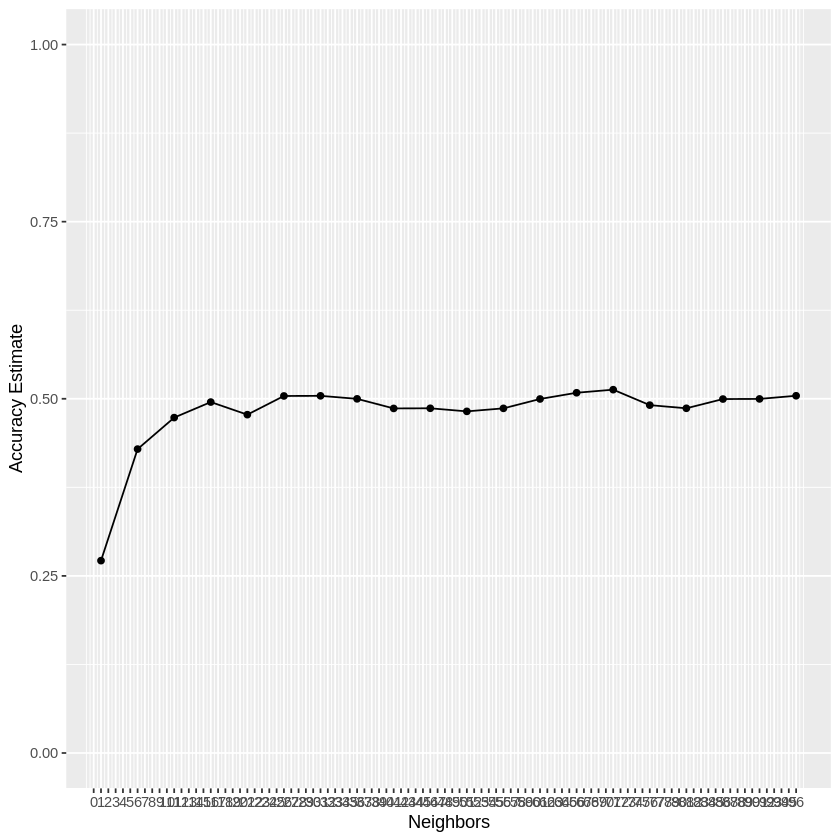

In [240]:
# Plot the accuracies for various values of k
accuracies <- vfold_metrics %>% 
    filter(.metric == "accuracy")
# accuracies

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, max(accuracies$neighbors), by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0, 1)) # adjusting the y-axis
accuracy_versus_k

In [241]:
# determine max accuracy, and k which achieves this max
max_accuracy <- accuracies %>%
    arrange(mean) %>%
    slice_tail() %>%
    select(neighbors, mean)
max_accuracy

# age + trestbps + thalach + chol
# 0.7099
# age + trestbps + thalach

neighbors,mean
<dbl>,<dbl>
71,0.5128502
